In [1]:
import os
os.environ["TMPDIR"] = "/tmp"  # set the folder for temporary files

import numpy as np
import qiskit
print(qiskit.__version__)
# from qiskit.opflow import StateFn, PauliExpectation, Zero, One,Z,X,I,Y,PauliOp,ListOp, AerPauliExpectation,DictStateFn,MatrixOp,PrimitiveOp, MatrixExpectation,ComposedOp
from qiskit.circuit.library import TwoLocal,EfficientSU2,UGate
# from qiskit.opflow.state_fns import CircuitStateFn
# from qiskit.opflow.converters import CircuitSampler
from qiskit import Aer
# from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.test.mock import FakeMontreal
from qiskit.providers.aer.noise import NoiseModel


from qiskit.chemistry.fermionic_operator import FermionicOperator
# from qiskit.providers.aer.library import SaveExpectationValueVariance

# from qiskit.algorithms.optimizers import COBYLA
# from qiskit.algorithms import VQE
# from qiskit_nature.converters.second_quantization import QubitConverter
# from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
# from qiskit.providers.aer import AerSimulator,QasmSimulator
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.quantum_info import Pauli

from random import random,seed
from math import pi
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from scipy.optimize import curve_fit
import pickle
# #my functions
# import ESfunctions
# import EnhancedSampling


def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

0.16.4


In [22]:

#Backend and Quantum instance
backend=Aer.get_backend('statevector_simulator')

#Hamiltonian

PauliH = WeightedPauliOperator([[1., Pauli(label ='Z')],[1., Pauli(label ='Y')],[1., Pauli(label ='X')]])
#PauliH = WeightedPauliOperator([[1., Pauli(label ='Z')]])

print('Operator to be measured',PauliH)

Operator to be measured Representation: paulis, qubits: 1, size: 3


1
 Random angles assigned to ansatz {Parameter(θ[0]): 2.9091610277393842, Parameter(θ[1]): 2.345588042336162, Parameter(θ[2]): 0.8704688011761168, Parameter(θ[3]): 5.444768683596541}


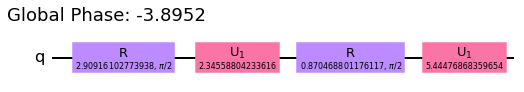

In [23]:
seed(9) #44 ok #494 wtf?
# Ansatz creation
# Define global variables
num_qubit = PauliH.num_qubits
print(num_qubit)
ansz = EfficientSU2(num_qubit,['ry','rz'],reps=1)
angles_set = {}
param = ansz.ordered_parameters
for j in range(len(param)):
    angles_set[param[j]]= random()*2*pi
ansz_assigned = ansz.bind_parameters(angles_set)

print(' Random angles assigned to ansatz',angles_set)
ansz_assigned.decompose().draw(output='mpl',filename='EfficientSU2')


In [24]:
# from qiskit import execute
# result = execute(
#     self.circs,
#     backend=Aer.get_backend("qasm_simulator"),
#     shots=num_shots,
# ).result()

# 
# print( 'Exact',exact_energy)

# exact_energy= 0


In [25]:
data_complete = pickle.load(open('data/hamiltonians.pickle', "rb"))
print(data_complete[3])


{'molecule': 'H2', 'basis': '631g', 'two_qubit_reduction': False, 'z2symmetry_reduction': False, 'freeze_core': False, 'mapping': 'jordan_wigner', 'operator': <qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator object at 0x7f7b833b3f40>, 'qubits': 8, 'num_paulis': 185, 'vqe_circuit': <qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes object at 0x7f7b832cbfd0>, 'vqe_value': -1.8321133743330758, 'exact_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f7b83bb85e0>, 'exact_value': -1.857258162076612, 'name': '8q H2 jordan_wigner'}


In [26]:
data = pickle.load(open('data/hamiltonians.pickle', "rb"))

h = data[3]

# qubitOp = h["operator"]

use_exact= False

if use_exact:
    qc = h["exact_circuit"]
    exact = h["exact_value"]
else:
    qc = h["vqe_circuit"]
    exact = h["vqe_value"]



# print('Circuit',qc)


if True:
    qc = ansz_assigned
    qubitOp = PauliH

print('exact value', exact)
print('Qubit Op:', qubitOp)
print('Circuit:', qc)

exact value -1.8321133743330758
Qubit Op: Representation: paulis, qubits: 1, size: 3
Circuit:      ┌──────────────────────┐┌──────────────────────┐┌───────────────────────┐»
q_0: ┤ RY(2.90916102773938) ├┤ RZ(2.34558804233616) ├┤ RY(0.870468801176117) ├»
     └──────────────────────┘└──────────────────────┘└───────────────────────┘»
«     ┌──────────────────────┐
«q_0: ┤ RZ(5.44476868359654) ├
«     └──────────────────────┘


In [27]:
qubitOp.to_opflow()

SummedOp([PauliOp(Pauli(z=[True], x=[False]), coeff=1.0), PauliOp(Pauli(z=[True], x=[True]), coeff=1.0), PauliOp(Pauli(z=[False], x=[True]), coeff=1.0)], coeff=1.0, abelian=False)

In [28]:
# # ###save data without 'operator'
# data_no_operator = data.copy()
# for elem in data_no_operator:
#     elem.pop('operator')
#     elem.pop('exact_circuit')
#     elem.pop('vqe_circuit')
# print(data)
# # save data_no_operator to pickle
# pickle.dump(data_no_operator, open("data/hamiltonians_no_operator.pickle", "wb"))


In [29]:
import logging
from povm.estimator import POVMEstimator,GradPOVMEstimator,GooglePOVMEstimator,PauliEstimator, GroupedPauliEstimator, GoogleGradPOVMEstimator

# logging.basicConfig(level=logging.DEBUG)

povm_optimal_params =[]

 

povm_test_params = np.array([0.25, 0.30408672, 0, 0.5, 0.5, 0.25, 0.5, 1])

_SIC_PARAMS = np.array([0.25, 0.30408672, 0.125, 0.5, 0.5, 0.25, 0.5, 0.75])


estimator = POVMEstimator(qc, qubitOp, exact, return_counts=False)#, povm_params=povm_test_params ) #povm_optimal_params
p_estimator = PauliEstimator(qc, qubitOp, exact, return_counts=False)
gp_estimator = GroupedPauliEstimator(qc, qubitOp, exact, return_counts=False)

#estimator = GoogleGradPOVMEstimator(qc, qubitOp, exact, return_counts=False)
grad_estimator = GradPOVMEstimator(qc, qubitOp, exact, return_counts=False)#, povm_params=povm_optimal_params)

paulis_dict: {'paulis': [{'label': 'Z', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'Y', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'X', 'coeff': {'real': 1.0, 'imag': 0.0}}]}
self._k: ['Z', 'Y', 'X']
self._c_k: [1.+0.j 1.+0.j 1.+0.j]
paulis_dict: {'paulis': [{'label': 'Z', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'Y', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'X', 'coeff': {'real': 1.0, 'imag': 0.0}}]}
self._k: ['Z', 'Y', 'X']
self._c_k: [1.+0.j 1.+0.j 1.+0.j]


In [40]:
num_shots=10000

print('shots:', num_shots)

#print(result)

print('\n Unoptimized POVM measurement:')
for result in estimator.estimate(num_shots):
    print('value',result['estimate'],', estimated_error',result['estimated_error'],' ,number of circuits', result['circuits'], ' ,shots per circuit',result['shots_per_circuit'])


# print('\nStandard Pauli measurement:')
# for result in p_estimator.estimate(num_shots):
#     print('value',result['estimate'],', estimated_error',result['estimated_error'],' ,number of circuits', result['circuits'], ' ,shots per circuit',result['shots_per_circuit'])

# print('\nGrouped Pauli measurement:')
# for result in gp_estimator.estimate(num_shots):
#     print('value',result['estimate'],', estimated_error',result['estimated_error'],' ,number of circuits', result['circuits'], ' ,shots per circuit',result['shots_per_circuit'])


# print('\n Optimized POVM measurement:')
# for result in grad_estimator.estimate(num_shots):
    
#     print('value',result['estimate'],', estimated_error',result['estimated_error'], 'shots',result['shots_per_circuit'],' ,number of circuits', result['circuits'])


# print('\nexact result',result['true'])
result

shots: 10000

 Unoptimized POVM measurement:
shots_per_circuit 10000 10000
result Result(backend_name='qasm_simulator', backend_version='0.7.5', qobj_id='4ff60997-bb1b-46c8-ae63-54d4b8038989', job_id='4ffff900-c86b-45a7-92a3-120dede9d9b3', success=True, results=[ExperimentResult(shots=10000, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x0': 1196, '0x1': 1824, '0x2': 4928, '0x3': 2052}), header=QobjExperimentHeader(clbit_labels=[['c4', 0], ['c4', 1]], creg_sizes=[['c4', 2]], global_phase=0.0, memory_slots=2, n_qubits=2, name='nlocal', qreg_sizes=[['q', 1], ['a', 1]], qubit_labels=[['q', 0], ['a', 0]]), status=DONE, seed_simulator=1725900112, time_taken=0.011480688000000001, metadata={'fusion': {'applied': False, 'enabled': True, 'method': 'unitary', 'threshold': 14}, 'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 8})], date=2022-07-27T18:03:53.393580, status=COMPLETED, status=QobjHeader(backend_name=

{'qubits': 1,
 'true': -1.8321133743330758,
 'estimate': -0.2883426854922607,
 'estimated_error': 0.025412187196482323,
 'error': 1.543770688840815,
 'circuits': 1,
 'shots_per_circuit': 10000,
 'shots': 10000,
 'time_qc': 0.021814584732055664,
 'time_post': 0.004364967346191406,
 'method': 'SIC-POVM',
 'counts': None,
 'povm_params': [0.25, 0.30408672, 0.125, 0.5, 0.5, 0.25, 0.5, 0.75]}

In [31]:
result['povm_params'] #0.020

[0.25, 0.30408672, 0.125, 0.5, 0.5, 0.25, 0.5, 0.75]

In [32]:
from povm.povm_operator import POVMOperator

sic_povm = POVMOperator(qubitOp, povm_params=result['povm_params'])

print(sic_povm._unitaries[0][0][0:2])
print(sic_povm._unitaries[0][1][0:2])
print(sic_povm._unitaries[0][2][0:2])
print(sic_povm._unitaries[0][3][0:2])
#print(sic_povm._povms[0])

print('SIC POVM')

sic_povm = POVMOperator(qubitOp, povm_params=_SIC_PARAMS)

print(sic_povm._unitaries[0][0][0:2])
print(sic_povm._unitaries[0][1][0:2])
print(sic_povm._unitaries[0][2][0:2])
print(sic_povm._unitaries[0][3][0:2])

paulis_dict: {'paulis': [{'label': 'Z', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'Y', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'X', 'coeff': {'real': 1.0, 'imag': 0.0}}]}
self._k: ['Z', 'Y', 'X']
self._c_k: [1.+0.j 1.+0.j 1.+0.j]
[7.07106781e-01+0.00000000e+00j 4.32978028e-17+4.32978028e-17j]
[0.4082483 +0.00000000e+00j 0.57735026+1.03545091e-17j]
[ 0.40824829+0.j  -0.28867514-0.5j]
[ 0.40824829+0.j  -0.28867514+0.5j]
SIC POVM
paulis_dict: {'paulis': [{'label': 'Z', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'Y', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'X', 'coeff': {'real': 1.0, 'imag': 0.0}}]}
self._k: ['Z', 'Y', 'X']
self._c_k: [1.+0.j 1.+0.j 1.+0.j]
[7.07106781e-01+0.00000000e+00j 4.32978028e-17+4.32978028e-17j]
[0.4082483 +0.00000000e+00j 0.57735026+1.03545091e-17j]
[ 0.40824829+0.j  -0.28867514-0.5j]
[ 0.40824829+0.j  -0.28867514+0.5j]


In [33]:
#test
from qiskit.chemistry.transformations import (FermionicTransformation,
                                              FermionicTransformationType,
                                              FermionicQubitMappingType)

fermionic_transformation_JW = FermionicTransformation(
            transformation=FermionicTransformationType.FULL,
            qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER,
            two_qubit_reduction=False,
            freeze_core=True)

fermionic_transformation_JKMN = FermionicTransformation(
            transformation=FermionicTransformationType.FULL,
            qubit_mapping=FermionicQubitMappingType.NEVEN,
            two_qubit_reduction=False,
            freeze_core=True)

from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')


In [34]:
from qiskit import BasicAer
from qiskit.aqua.algorithms import VQE
from qiskit.aqua import QuantumInstance
from qiskit.chemistry.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCSDFactory

vqe_solver = VQEUCCSDFactory(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

num_qubits = 4
tl_circuit = TwoLocal(num_qubits, ['h', 'rx'], 'cz',
                      entanglement='full', reps=3, parameter_prefix = 'y')

tl_circuit.draw(output = 'mpl')

another_solver = VQE(var_form = tl_circuit,
                     quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator')))

In [35]:
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver

calc = GroundStateEigensolver(fermionic_transformation_JW, another_solver)
res = calc.solve(driver)

print(res)


calc = GroundStateEigensolver(fermionic_transformation_JKMN, another_solver)
res = calc.solve(driver)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857274890503
  - computed part:      -1.857274890503
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137305896054
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894863]
    - computed part:      [0.0  0.0  1.38894863]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.00000007]  Total: 0.00000007
                 (debye): [0.0  0.0  0.00000017]  Total: 0.00000017
 
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.55317985607
  - computed part:      -1.55317985607
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repul

### Extras

In [36]:
qubit_op, _ = fermionic_transformation_JW.transform(driver)
print(qubit_op)
print(fermionic_transformation_JW.molecule_info)

SummedOp([
  -0.8105479805373261 * IIII,
  0.17218393261915532 * IIIZ,
  -0.22575349222402513 * IIZI,
  0.17218393261915535 * IZII,
  -0.2257534922240251 * ZIII,
  0.12091263261776639 * IIZZ,
  0.16892753870087923 * IZIZ,
  0.04523279994605789 * XXYY,
  0.04523279994605789 * YYYY,
  0.04523279994605789 * XXXX,
  0.04523279994605789 * YYXX,
  0.16614543256382427 * ZIIZ,
  0.16614543256382427 * IZZI,
  0.1746434306830047 * ZIZI,
  0.12091263261776639 * ZZII
])
{'num_particles': [1, 1], 'num_orbitals': 4, 'two_qubit_reduction': False, 'z2_symmetries': <qiskit.aqua.operators.legacy.weighted_pauli_operator.Z2Symmetries object at 0x7f7b6d731eb0>}


In [37]:
qubit_op, _ = fermionic_transformation_JKMN.transform(driver)
print('JKMN:\n',qubit_op)
print(fermionic_transformation_JW.molecule_info)

JKMN:
 SummedOp([
  -0.8105479805373261 * IIII,
  0.17218393261915532 * IZII,
  -0.22575349222402513 * ZZXI,
  0.17218393261915535 * IIXI,
  -0.2257534922240251 * IIIZ,
  0.12091263261776639 * ZIXI,
  0.16892753870087923 * IZXI,
  -0.04523279994605789 * YXYX,
  -0.04523279994605789 * YXZY,
  0.04523279994605789 * XXZX,
  -0.04523279994605789 * XXYY,
  0.16614543256382427 * IZIZ,
  0.16614543256382427 * ZZII,
  0.1746434306830047 * ZZXZ,
  0.12091263261776639 * IIXZ
])
{'num_particles': [1, 1], 'num_orbitals': 4, 'two_qubit_reduction': False, 'z2_symmetries': <qiskit.aqua.operators.legacy.weighted_pauli_operator.Z2Symmetries object at 0x7f7b6d731eb0>}
